# Introduction to Modern Portfolio Theory (MPT)

### Thomas Polstra, PhD

##### [GitHub](https://github.com/thomaspolstra/Quant_Materials_Polstra_Public.git) -- [Academic Website](https://thomaspolstra.github.io/) -- [Email](mailto:thomaspolstra@gmail.com)

## Purpose of the Notebook

The primary goal of this notebook is to the significance of Modern Portfolio Theory in the world of investment. Modern Portfolio Theory, developed by Nobel laureate Harry Markowitz in the 1950s, revolutionized the way investors approach the construction of their investment portfolios.

## Overview of Modern Portfolio Theory

Modern Portfolio Theory is a powerful framework that aims to optimize investment decisions by considering the risk and return trade-offs of various assets within a portfolio. The theory is built on the core idea that investors can maximize returns while minimizing risks through diversification.

## Key Concepts to Explore

In this notebook, we will explore two key concepts of Modern Portfolio Theory:

1. **Sharpe Ratio (Risk-to-Reward Ratio)**: The Sharpe Ratio is a crucial metric used to assess the risk-adjusted performance of an investment portfolio. It quantifies the excess return earned per unit of risk taken by the portfolio. We will dive into the calculation and interpretation of the Sharpe Ratio to understand how it helps investors make informed decisions.

2. **Diversification**: Diversification is a cornerstone principle of Modern Portfolio Theory. By combining different assets with low correlations, investors can reduce overall portfolio risk without sacrificing returns. We will explore the concept of diversification, its benefits, and how it can lead to more stable and efficient portfolios.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import scipy.optimize as sc

sns.set_style('darkgrid')

# Function Descriptions:

1. `getData(stocks, start, end)`: This function imports historical stock price data for a given list of `stocks` over the specified `start` and `end` dates using the `yfinance` library. It then calculates the daily returns for each stock, computes the mean returns, and constructs the covariance matrix for the returns. The function returns three main variables: `meanReturns`, which is a pandas Series containing the mean returns for each stock, `covMatrix`, which is a pandas DataFrame representing the covariance matrix of returns, and `stockData`, which is a pandas DataFrame containing the historical stock prices.

2. `plotPrices(stocks, start, end)`: This function uses the `getData` function to retrieve historical stock prices and then plots the prices of the specified `stocks` over the specified `start` and `end` dates. It uses Matplotlib to create the plot, labeling the x-axis as "Date" and the y-axis as "Price". Each stock is represented by a different colored line, and the plot includes a legend to distinguish between the stocks.

3. `portfolioPerformance(weights, meanReturns, covMatrix)`: This function calculates the expected portfolio return and volatility (standard deviation) for a given set of portfolio `weights`, mean returns (`meanReturns`), and the covariance matrix of returns (`covMatrix`). It uses the formula for portfolio return and volatility based on the weighted sum of individual asset returns and covariances. The function returns the expected portfolio return (`returns`) and portfolio volatility (`std`).

These functions are useful for analyzing the performance of portfolios constructed from multiple assets and for visualizing historical stock price data.


In [2]:
# Import data
def getData(stocks, start, end):
    stockData = yf.download(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change().dropna()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix, stockData

def plotPrices(stocks,start,end):
    meanReturns, covMatrix, stockData = getData(stocks, start, end)
    for stock in stocks:
        plt.plot(stockData[stock], label = stock)
        plt.plot(stockData)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Stock Prices', size = 20)
        plt.legend()
        
def portfolioPerformance(weights, meanReturns, covMatrix):
    returns = np.sum(meanReturns*weights)*252
    std = np.sqrt(
            np.dot(weights.T,np.dot(covMatrix, weights))
           )*np.sqrt(252)
    return returns, std

In [21]:
stocks = ['AAPL', 'TSLA', 'MSFT']
end = datetime.date.today()
start = end - datetime.timedelta(days = 365)
meanReturns, covMatrix, stockData = getData(stocks, start, end)

[*********************100%***********************]  3 of 3 completed


[*********************100%***********************]  3 of 3 completed


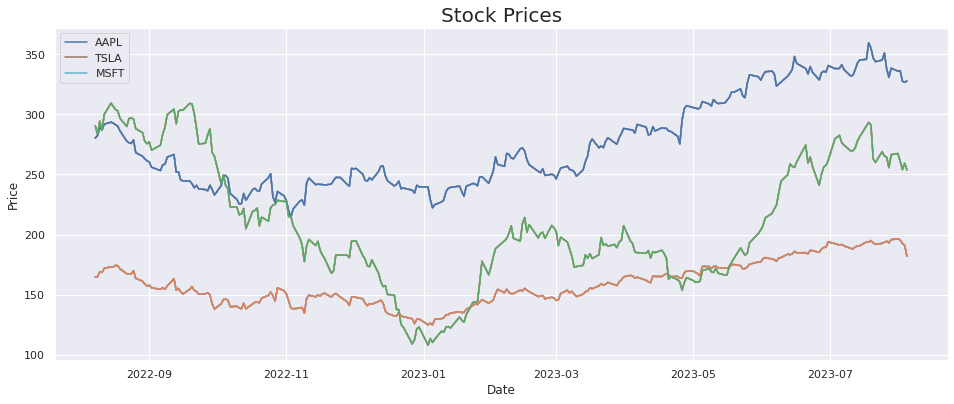

In [5]:
plotPrices(stocks,start,end)
plt.show()

In [6]:
weights = np.array([.25, .3, .45])
r, v = portfolioPerformance(weights, meanReturns, covMatrix)
print(f'Returns: {round(r*100, 2)}%')
print(f'Volatility: {round(v*100, 2)}%')
print(f'Sharpe Ratio: {round(r/v,2)}')

Returns: 11.75%
Volatility: 36.7%
Sharpe Ratio: 0.32


## Optimizing Portfolio Weights

Optimizing portfolio weights is a crucial step in Modern Portfolio Theory (MPT) to achieve the best risk-reward balance.
- Functions are designed to find the combination of asset weights that maximizes the Sharpe Ratio (SR), a measure of the portfolio's risk-adjusted return. A higher Sharpe Ratio indicates a better risk-reward profile.

- Functions are designed to find the combination of asset weights that minimize volatility,

### Functions:

1. `negativeSR(weights, meanReturns, covMatrix, riskFreeRate = 0)`: This function calculates the negative Sharpe Ratio for a given set of portfolio `weights`, mean returns (`meanReturns`), covariance matrix of returns (`covMatrix`), and the risk-free rate (`riskFreeRate`). It uses the `portfolioPerformance` function to compute the portfolio's expected return and standard deviation. The negative Sharpe Ratio is used because we want to minimize it during optimization.

2. `maxSR(meanReturns, covMatrix, riskFreeRate = 0, constraintSet=(0,1))`: This function performs the optimization process to find the portfolio weights that maximize the Sharpe Ratio. It takes the mean returns (`meanReturns`), covariance matrix of returns (`covMatrix`), and the risk-free rate (`riskFreeRate`) as inputs. The optional `constraintSet` parameter defines the minimum and maximum bounds for the asset weights. The optimization is done using the Sequential Least Squares Programming (SLSQP) method, subject to the constraint that the sum of all asset weights must be equal to 1.

3. `portfolioVariance(weights, meanReturns, covMatrix)`: This function calculates the portfolio variance for a given set of portfolio `weights`, mean returns (`meanReturns`), and the covariance matrix of returns (`covMatrix`). It utilizes the `portfolioPerformance` function to compute the portfolio's expected return and standard deviation and then returns the variance.

4. `minimizeVariance(meanReturns, covMatrix, constraintSet=(0,1))`: This function performs the optimization process to find the portfolio weights that minimize the portfolio variance. It takes the mean returns (`meanReturns`) and covariance matrix of returns (`covMatrix`) as inputs. The optional `constraintSet` parameter defines the minimum and maximum bounds for the asset weights. The optimization is carried out using the Sequential Least Squares Programming (SLSQP) method, subject to the constraint that the sum of all asset weights must be equal to 1. The objective is to find the allocation of assets that minimizes the overall portfolio variance.

The `maxSR` function returns the result of the optimization, which contains the optimal portfolio weights that maximize the Sharpe Ratio.



In [7]:
def negativeSR(weights, meanReturns, covMatrix, riskFreeRate = 0):
    pReturns, pStd = portfolioPerformance(weights, meanReturns, covMatrix)
    return - (pReturns - riskFreeRate)/pStd

def maxSR(meanReturns, covMatrix, riskFreeRate = 0, constraintSet=(0,1)):
    "Minimize the negative SR, by altering the weights of the portfolio"
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(negativeSR, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolioVariance(weights, meanReturns, covMatrix):
    return portfolioPerformance(weights, meanReturns, covMatrix)[1]

def minimizeVariance(meanReturns, covMatrix, constraintSet=(0,1)):
    """Minimize the portfolio variance by altering the 
     weights/allocation of assets in the portfolio"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(portfolioVariance, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [12]:
weights  = maxSR(meanReturns, covMatrix, riskFreeRate = 0).x
r, v = portfolioPerformance(weights, meanReturns, covMatrix)
print(f'Asset weights: {weights}')
print(f'Returns: {round(r*100, 2)}%')
print(f'Volatility: {round(v*100, 2)}%')
print(f'Sharpe Ratio: {round(r/v,2)}')

Asset weights: [0.08271457 0.91728543 0.        ]
Returns: 20.28%
Volatility: 30.86%
Sharpe Ratio: 0.66


In [20]:
weights = minimizeVariance(meanReturns, covMatrix).x
r, v = portfolioPerformance(weights, meanReturns, covMatrix)
print(f'Asset weights: {weights}')
print(f'Returns: {round(r*100, 2)}%')
print(f'Volatility: {round(v*100, 2)}%')
print(f'Sharpe Ratio: {round(r/v,2)}')

Asset weights: [0.64457018 0.35542982 0.        ]
Returns: 16.56%
Volatility: 27.88%
Sharpe Ratio: 0.59


## Diversification in Portfolio Management

Diversification is a fundamental concept in portfolio management that involves spreading investments across a variety of assets to reduce risk. The goal of diversification is to achieve a balance between risk and return, thereby maximizing the potential for positive returns while minimizing exposure to any single asset's risk.

### Benefits of Diversification

1. Risk Reduction: By investing in a diverse range of assets, the risk associated with individual securities is diluted. This can help protect the overall portfolio from severe losses that may occur if a single asset performs poorly.

2. Smoother Returns: Diversification can lead to more stable and consistent portfolio returns over time, as the positive performance of some assets can offset the negative performance of others.

3. Opportunity for Growth: By diversifying across different industries and sectors, investors can capitalize on growth opportunities in various areas of the economy.

4. Lower Correlation: Assets from different industries often have different price movements, reducing the correlation between them. Lower correlation means that the assets are less likely to move in the same direction at the same time.

### Optimal Weight Allocation

To achieve the benefits of diversification, investors need to allocate their capital across different assets based on their risk tolerance, investment objectives, and market conditions. The optimal weight allocation involves finding the right balance between risk and reward.

For this exercise, we will consider 15 various stock tickers from the S&P 500 index, representing different industries and sectors. We will use two different approaches to optimize the portfolio:

1. Maximize Sharpe Ratio: We will find the weights that maximize the Sharpe Ratio, which measures the risk-adjusted return of the portfolio. A higher Sharpe Ratio indicates better risk-adjusted performance.

2. Minimize Volatility: We will seek the weights that minimize the portfolio's volatility, which measures the standard deviation of returns. Lower volatility implies a smoother and less risky performance.

The tickers we will consider are:
1. AAPL - Apple Inc. (Technology)
2. MSFT - Microsoft Corporation (Technology)
3. JPM - JPMorgan Chase & Co. (Financials)
4. V - Visa Inc. (Financials)
5. PG - Procter & Gamble Company (Consumer Staples)
6. NFLX - Netflix, Inc. (Communication Services)
7. UNH - UnitedHealth Group Incorporated (Health Care)
8. ABBV - AbbVie Inc. (Health Care)
9. BA - The Boeing Company (Industrials)
10. XOM - Exxon Mobil Corporation (Energy)
11. WMT - Walmart Inc. (Consumer Discretionary)
12. DIS - The Walt Disney Company (Communication Services)
13. PFE - Pfizer Inc. (Health Care)
14. KO - The Coca-Cola Company (Consumer Staples)
15. AMZN - Amazon.com, Inc. (Consumer Discretionary)

Let's proceed with the optimization process to find the optimal weights for the portfolio based on the Sharpe Ratio and minimizing volatility.

[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed


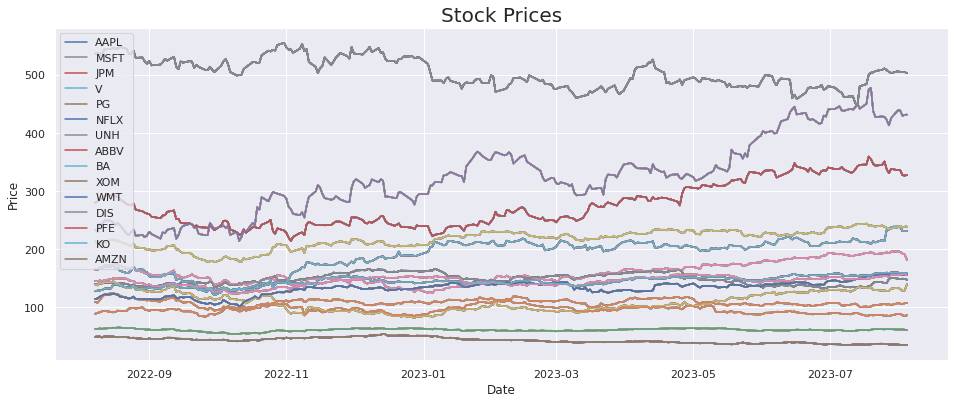

In [23]:
stocks = ['AAPL', 'MSFT', 'JPM', 'V', 'PG', 'NFLX', 'UNH', 'ABBV', 'BA', 'XOM', 'WMT', 'DIS', 'PFE', 'KO', 'AMZN']
end = datetime.date.today()
start = end - datetime.timedelta(days = 365)
meanReturns, covMatrix, stockData = getData(stocks, start, end)
plotPrices(stocks,start,end)
plt.show()

In [24]:
#Maximize Sharpe Ratio of a Portfolio with investment in stocks
weights  = maxSR(meanReturns, covMatrix, riskFreeRate = 0).x
r, v = portfolioPerformance(weights, meanReturns, covMatrix)
print(f'Asset weights: {weights}')
print(f'Returns: {round(r*100, 2)}%')
print(f'Volatility: {round(v*100, 2)}%')
print(f'Sharpe Ratio: {round(r/v,2)}')

Asset weights: [0.00000000e+00 6.55073036e-16 4.77221098e-16 1.02204265e-01
 0.00000000e+00 2.49082203e-01 5.35868622e-16 6.54751925e-16
 2.38659080e-01 0.00000000e+00 1.15335396e-15 3.76194676e-16
 4.01411638e-16 4.03111353e-01 6.94309943e-03]
Returns: 39.75%
Volatility: 20.49%
Sharpe Ratio: 1.94


In [26]:
#Minimize Volatility of a Portfolio with investment in stocks
weights = minimizeVariance(meanReturns, covMatrix).x
r, v = portfolioPerformance(weights, meanReturns, covMatrix)
print(f'Asset weights: {weights}')
print(f'Returns: {round(r*100, 2)}%')
print(f'Volatility: {round(v*100, 2)}%')
print(f'Sharpe Ratio: {round(r/v,2)}')

Asset weights: [6.10268745e-18 9.30857770e-02 0.00000000e+00 1.40255722e-17
 8.39389882e-18 0.00000000e+00 2.99344141e-01 0.00000000e+00
 0.00000000e+00 5.61045911e-02 1.77483946e-01 8.86292092e-02
 3.47740115e-02 1.71777264e-01 7.88010607e-02]
Returns: 5.54%
Volatility: 13.09%
Sharpe Ratio: 0.42


## Conclusion

In this notebook, we explored the concepts of Sharpe Ratio and diversification in the context of Modern Portfolio Theory. The Sharpe Ratio served as a valuable measure of a portfolio's risk-adjusted returns, providing insights into the efficiency of an investment strategy. By maximizing the Sharpe Ratio, we aimed to find the optimal portfolio weights that offer the highest risk-to-reward ratio.

Diversification played a critical role in portfolio optimization by spreading risk across various assets. Through diversification, we aimed to minimize the overall portfolio volatility and reduce exposure to individual asset risks. By combining assets from different industries and sectors, we effectively reduced the impact of adverse price movements in any single asset, leading to a more stable and robust portfolio.

Beyond applying these concepts to individual assets, the same principles can be extended to optimize investment strategies. Strategies can be viewed as portfolios of different trading positions, each with its risk and return characteristics. By considering different strategy components as assets, we can diversify the strategy portfolio to achieve better risk-adjusted returns. Maximizing the Sharpe Ratio for strategies allows us to identify the most efficient trading approaches, leading to more successful and consistent trading performance.

In summary, understanding the Sharpe Ratio and the power of diversification is fundamental to creating robust and efficient portfolios, whether for individual assets or complex trading strategies. By leveraging these principles, investors and traders can make informed decisions that align with their risk appetite and financial goals.